In [2]:
import pandas as pd

In [3]:
customers_df=pd.read_csv('Downloads/customers1.csv')

In [4]:
offers_df = pd.read_csv('Downloads/offers.csv')

In [5]:
events_df=pd.read_csv('Downloads/events_N.csv')

In [6]:
events_df

customer_id           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306132  b3a1272bc9904337b331bf348c3e8c17     transaction   
306133  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306134  a00058cf10334a308c68e7631c529907     transaction   
306135  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306136  c02b10e8752c4d8e9b73f918558531f7     transaction   

                               offer_ids  transaction_amount  rewardamt  time  
0       9b98b8c7a33c4b65b9aebfe6a799e6d9                0.00          0     0  
1       0b1e1539f2cc45b7b9fa7c272da2e1d7                0.00          0     0  
2       2906b810c7d4411798c6938adc9daaa5                0.00          0     0  
3       fafdcd668e3743c1bb461111dcafc2a4                0.00          0     0  
4       4d5c57ea9a6940dd891ad53e9dbe8da0                0.00          0     0  
...                                  ...                 ...        ...   ...  
306132                               NaN                1.59          0   714  
306133                               NaN                9.53          0   714  
306134                               NaN                3.61          0   714  
306135                               NaN                3.53          0   714  
306136                               NaN                4.05          0   714  

[306137 rows x 6 columns]

In [8]:
# Convert 'became_member_on' to datetime without specifying format since it's already in 'YYYY-MM-DD'
customers_df['became_member_on'] = pd.to_datetime(customers_df['became_member_on'])


In [9]:
# Calculate membership duration in days from a reference date (assumed '2022-01-01')
reference_date = pd.Timestamp('2022-01-01')
customers_df['membership_duration_days'] = (reference_date - customers_df['became_member_on']).dt.days


In [10]:
# Merge events with offers to get offer type details
events_df = events_df.merge(offers_df, left_on='offer_ids', right_on='offer_id', how='left')


In [11]:
# Merge events with customer demographics
events_df = events_df.merge(customers_df, on='customer_id', how='left')


In [12]:
# Historical transaction counts per customer
transaction_counts = events_df.groupby('customer_id')['transaction_amount'].count().reset_index()
transaction_counts.rename(columns={'transaction_amount': 'historical_transaction_count'}, inplace=True)


In [13]:
# Total transaction amount per customer
total_transaction_amount = events_df.groupby('customer_id')['transaction_amount'].sum().reset_index()
total_transaction_amount.rename(columns={'transaction_amount': 'total_spent'}, inplace=True)


In [14]:
# Merge with events data
events_df = events_df.merge(transaction_counts, on='customer_id', how='left')
events_df = events_df.merge(total_transaction_amount, on='customer_id', how='left')


In [15]:
# Calculate time since last transaction for each customer
events_df['last_transaction_time'] = events_df.groupby('customer_id')['time'].shift(1)
events_df['time_since_last_transaction'] = events_df['time'] - events_df['last_transaction_time']
events_df['time_since_last_transaction'].fillna(events_df['time'], inplace=True)  # Fill NaN with first transaction time


In [16]:
# Selecting relevant features for prediction
features_df = events_df[[
    'customer_id', 'event', 'offer_type', 'age', 'gender', 'income', 'membership_duration_days',
    'historical_transaction_count', 'total_spent', 'time_since_last_transaction'
]]

In [18]:
features_df


customer_id           event offer_type   age  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received       bogo  75.0   
1       a03223e636434f42ac4c3df47e8bac43  offer received   discount   NaN   
2       e2127556f4f64592b11af22de27a7932  offer received   discount  68.0   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   discount   NaN   
4       68617ca6246f4fbc85e91a2a49552598  offer received       bogo   NaN   
...                                  ...             ...        ...   ...   
306132  b3a1272bc9904337b331bf348c3e8c17     transaction        NaN  66.0   
306133  68213b08d99a4ae1b0dcb72aebd9aa35     transaction        NaN  52.0   
306134  a00058cf10334a308c68e7631c529907     transaction        NaN  63.0   
306135  76ddbd6576844afe811f1a3c0fbb5bec     transaction        NaN  57.0   
306136  c02b10e8752c4d8e9b73f918558531f7     transaction        NaN   NaN   

       gender    income  membership_duration_days  \
0           F  100000.0                    1698.0   
1         NaN       NaN                       NaN   
2           M   70000.0                    1346.0   
3         NaN       NaN                       NaN   
4         NaN       NaN                       NaN   
...       ...       ...                       ...   
306132      M   47000.0                    1461.0   
306133      M   62000.0                    1364.0   
306134      F   52000.0                    3023.0   
306135      M   40000.0                    2002.0   
306136    NaN       NaN                       NaN   

        historical_transaction_count  total_spent  time_since_last_transaction  
0                                 18       159.27                          0.0  
1                                 11         4.65                          0.0  
2                                 12        57.73                          0.0  
3                                 10         0.00                          0.0  
4                                 11         0.24                          0.0  
...                              ...          ...                          ...  
306132                            20        58.00                        156.0  
306133                            10        10.01                        138.0  
306134                            33        63.05                          6.0  
306135                            20       135.62                         36.0  
306136                            16        12.78                        198.0  

[306137 rows x 10 columns]

In [19]:
# Handle missing values
numerical_cols = ['age', 'income', 'membership_duration_days', 'historical_transaction_count', 
                  'total_spent', 'time_since_last_transaction']
categorical_cols = ['offer_type', 'gender']

In [21]:
# Fill missing numerical values with median
features_df[numerical_cols] = features_df[numerical_cols].fillna(features_df[numerical_cols].median())

# Fill missing categorical values with mode
for col in categorical_cols:
    features_df[col] = features_df[col].fillna(features_df[col].mode()[0])


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\3466381061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df[numerical_cols] = features_df[numerical_cols].fillna(features_df[numerical_cols].median())
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\3466381061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df[col] = features_df[col].fillna(features_df[col].mode()[0])


In [22]:
# Fill missing numerical values with median
features_df[numerical_cols] = features_df[numerical_cols].fillna(features_df[numerical_cols].median())


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\2963234036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df[numerical_cols] = features_df[numerical_cols].fillna(features_df[numerical_cols].median())


In [23]:
features_df

customer_id           event offer_type   age  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received       bogo  75.0   
1       a03223e636434f42ac4c3df47e8bac43  offer received   discount  55.0   
2       e2127556f4f64592b11af22de27a7932  offer received   discount  68.0   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   discount  55.0   
4       68617ca6246f4fbc85e91a2a49552598  offer received       bogo  55.0   
...                                  ...             ...        ...   ...   
306132  b3a1272bc9904337b331bf348c3e8c17     transaction       bogo  66.0   
306133  68213b08d99a4ae1b0dcb72aebd9aa35     transaction       bogo  52.0   
306134  a00058cf10334a308c68e7631c529907     transaction       bogo  63.0   
306135  76ddbd6576844afe811f1a3c0fbb5bec     transaction       bogo  57.0   
306136  c02b10e8752c4d8e9b73f918558531f7     transaction       bogo  55.0   

       gender    income  membership_duration_days  \
0           F  100000.0                    1698.0   
1           M   62000.0                    1726.0   
2           M   70000.0                    1346.0   
3           M   62000.0                    1726.0   
4           M   62000.0                    1726.0   
...       ...       ...                       ...   
306132      M   47000.0                    1461.0   
306133      M   62000.0                    1364.0   
306134      F   52000.0                    3023.0   
306135      M   40000.0                    2002.0   
306136      M   62000.0                    1726.0   

        historical_transaction_count  total_spent  time_since_last_transaction  
0                                 18       159.27                          0.0  
1                                 11         4.65                          0.0  
2                                 12        57.73                          0.0  
3                                 10         0.00                          0.0  
4                                 11         0.24                          0.0  
...                              ...          ...                          ...  
306132                            20        58.00                        156.0  
306133                            10        10.01                        138.0  
306134                            33        63.05                          6.0  
306135                            20       135.62                         36.0  
306136                            16        12.78                        198.0  

[306137 rows x 10 columns]

In [26]:
features_df['membership_transaction_interaction'] = features_df['membership_duration_days'] * features_df['historical_transaction_count']


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\644183457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['membership_transaction_interaction'] = features_df['membership_duration_days'] * features_df['historical_transaction_count']


In [27]:
features_df['income_spent_ratio'] = features_df['total_spent'] / features_df['income'].replace(0, 1)  # Prevent division by zero


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\3045193409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['income_spent_ratio'] = features_df['total_spent'] / features_df['income'].replace(0, 1)  # Prevent division by zero


In [28]:
features_df['time_transaction_ratio'] = features_df['time_since_last_transaction'] / (features_df['historical_transaction_count'] + 1)  # Prevent division by zero


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\3012167645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['time_transaction_ratio'] = features_df['time_since_last_transaction'] / (features_df['historical_transaction_count'] + 1)  # Prevent division by zero


In [29]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
categorical_columns = ['event', 'offer_type', 'gender']

# Initialize LabelEncoder and apply encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    features_df[col] = le.fit_transform(features_df[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoder for potential inverse transformation


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1737604522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df[col] = le.fit_transform(features_df[col].astype(str))  # Convert to string before encoding
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1737604522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df[col] = le.fit_transform(features_df[col].astype(str))  # Convert to string before encoding
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1737604522.py:10: SettingWit

In [30]:
features_df

customer_id  event  offer_type   age  gender  \
0       78afa995795e4d85b5d9ceeca43f5fef      1           0  75.0       0   
1       a03223e636434f42ac4c3df47e8bac43      1           1  55.0       1   
2       e2127556f4f64592b11af22de27a7932      1           1  68.0       1   
3       8ec6ce2a7e7949b1bf142def7d0e0586      1           1  55.0       1   
4       68617ca6246f4fbc85e91a2a49552598      1           0  55.0       1   
...                                  ...    ...         ...   ...     ...   
306132  b3a1272bc9904337b331bf348c3e8c17      3           0  66.0       1   
306133  68213b08d99a4ae1b0dcb72aebd9aa35      3           0  52.0       1   
306134  a00058cf10334a308c68e7631c529907      3           0  63.0       0   
306135  76ddbd6576844afe811f1a3c0fbb5bec      3           0  57.0       1   
306136  c02b10e8752c4d8e9b73f918558531f7      3           0  55.0       1   

          income  membership_duration_days  historical_transaction_count  \
0       100000.0                    1698.0                            18   
1        62000.0                    1726.0                            11   
2        70000.0                    1346.0                            12   
3        62000.0                    1726.0                            10   
4        62000.0                    1726.0                            11   
...          ...                       ...                           ...   
306132   47000.0                    1461.0                            20   
306133   62000.0                    1364.0                            10   
306134   52000.0                    3023.0                            33   
306135   40000.0                    2002.0                            20   
306136   62000.0                    1726.0                            16   

        total_spent  time_since_last_transaction  \
0            159.27                          0.0   
1              4.65                          0.0   
2             57.73                          0.0   
3              0.00                          0.0   
4              0.24                          0.0   
...             ...                          ...   
306132        58.00                        156.0   
306133        10.01                        138.0   
306134        63.05                          6.0   
306135       135.62                         36.0   
306136        12.78                        198.0   

        membership_transaction_interaction  income_spent_ratio  \
0                                  30564.0            0.001593   
1                                  18986.0            0.000075   
2                                  16152.0            0.000825   
3                                  17260.0            0.000000   
4                                  18986.0            0.000004   
...                                    ...                 ...   
306132                             29220.0            0.001234   
306133                             13640.0            0.000161   
306134                             99759.0            0.001213   
306135                             40040.0            0.003391   
306136                             27616.0            0.000206   

        time_transaction_ratio  
0                     0.000000  
1                     0.000000  
2                     0.000000  
3                     0.000000  
4                     0.000000  
...                        ...  
306132                7.428571  
306133               12.545455  
306134                0.176471  
306135                1.714286  
306136               11.647059  

[306137 rows x 13 columns]

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report


In [35]:
# Define target variable: "offer redemption" (assuming event type 'offer completed' means redemption)
features_df['offer_redeemed'] = (features_df['event'] == 2).astype(int)  # Assuming label-encoded 'offer completed' is 2


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\538348489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['offer_redeemed'] = (features_df['event'] == 2).astype(int)  # Assuming label-encoded 'offer completed' is 2


In [36]:
# Select feature columns (excluding non-numeric and target variable)
X = features_df.drop(columns=['customer_id', 'event', 'offer_redeemed'])  # Drop categorical IDs and target
y = features_df['offer_redeemed']

In [38]:
# Handle missing values (e.g., membership_duration_days)
X.fillna(X.median(), inplace=True)


In [39]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [41]:
# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


LogisticRegression()

In [42]:
# Predict on test set
y_pred = log_reg.predict(X_test)


In [43]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [44]:
evaluation_results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Classification Report": report
}

In [45]:
evaluation_results


{'Accuracy': 0.8148396158620239,
 'Precision': 0.5452961672473867,
 'Recall': 0.10844521437851884,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.83      0.98      0.90     49683\n           1       0.55      0.11      0.18     11545\n\n    accuracy                           0.81     61228\n   macro avg       0.69      0.54      0.54     61228\nweighted avg       0.77      0.81      0.76     61228\n'}

In [46]:
from sklearn.tree import DecisionTreeClassifier


In [47]:
# Train a Decision Tree model (more memory-efficient than logistic regression)
dt_model = DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42)


In [48]:
dt_model = DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate model performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

# Display results
dt_evaluation_results = {
    "Accuracy": accuracy_dt,
    "Precision": precision_dt,
    "Recall": recall_dt,
    "Classification Report": report_dt
}

dt_evaluation_results

{'Accuracy': 0.7688639184686744,
 'Precision': 0.42116722104626547,
 'Recall': 0.6032048505846687,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.81      0.85     49683\n           1       0.42      0.60      0.50     11545\n\n    accuracy                           0.77     61228\n   macro avg       0.66      0.71      0.67     61228\nweighted avg       0.81      0.77      0.78     61228\n'}

In [49]:
# Manually create selected interaction terms to avoid memory issues
features_df['offer_income_interaction'] = features_df['offer_type'] * features_df['income']
features_df['membership_transaction_interaction'] = features_df['membership_duration_days'] * features_df['historical_transaction_count']


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\570681266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['offer_income_interaction'] = features_df['offer_type'] * features_df['income']
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\570681266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['membership_transaction_interaction'] = features_df['membership_duration_days'] * features_df['historical_transaction_count']


In [50]:

# Select updated features
X_selected = features_df[[
    'offer_type', 'age', 'income', 'membership_duration_days', 'historical_transaction_count',
    'total_spent', 'time_since_last_transaction', 'offer_income_interaction', 'membership_transaction_interaction'
]]

# Standardize selected features
X_selected_scaled = scaler.fit_transform(X_selected)

# Split dataset into train and test sets again
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression model with selected engineered features
log_reg_sel = LogisticRegression(max_iter=500, class_weight="balanced", solver="lbfgs")
log_reg_sel.fit(X_train_sel, y_train_sel)

# Predict on test set
y_pred_sel = log_reg_sel.predict(X_test_sel)

# Evaluate model performance
accuracy_sel = accuracy_score(y_test_sel, y_pred_sel)
precision_sel = precision_score(y_test_sel, y_pred_sel)
recall_sel = recall_score(y_test_sel, y_pred_sel)
report_sel = classification_report(y_test_sel, y_pred_sel)

# Display results
log_reg_selected_results = {
    "Accuracy": accuracy_sel,
    "Precision": precision_sel,
    "Recall": recall_sel,
    "Classification Report": report_sel
}

log_reg_selected_results

{'Accuracy': 0.7054125563467695,
 'Precision': 0.34764854970430864,
 'Recall': 0.6415764400173235,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.72      0.80     49683\n           1       0.35      0.64      0.45     11545\n\n    accuracy                           0.71     61228\n   macro avg       0.62      0.68      0.62     61228\nweighted avg       0.79      0.71      0.73     61228\n'}

In [52]:
# Train logistic regression with built-in class balancing
log_reg_weighted = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")
log_reg_weighted.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=500)

In [53]:

# Predict on test set
y_pred_weighted = log_reg_weighted.predict(X_test)

# Evaluate model performance
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
precision_weighted = precision_score(y_test, y_pred_weighted)
recall_weighted = recall_score(y_test, y_pred_weighted)
report_weighted = classification_report(y_test, y_pred_weighted)

# Display results
log_reg_weighted_results = {
    "Accuracy": accuracy_weighted,
    "Precision": precision_weighted,
    "Recall": recall_weighted,
    "Classification Report": report_weighted
}

log_reg_weighted_results

{'Accuracy': 0.7064088325602665,
 'Precision': 0.3490446457912774,
 'Recall': 0.6440017323516674,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.72      0.80     49683\n           1       0.35      0.64      0.45     11545\n\n    accuracy                           0.71     61228\n   macro avg       0.62      0.68      0.63     61228\nweighted avg       0.79      0.71      0.73     61228\n'}

In [54]:
# Create offer type interaction feature
features_df['offer_type_income_interaction'] = features_df['offer_type'] * features_df['income']

# Select updated features
X_interaction = features_df[[
    'offer_type', 'age', 'income', 'membership_duration_days', 'historical_transaction_count',
    'total_spent', 'time_since_last_transaction', 'offer_type_income_interaction'
]]

# Standardize selected features
X_interaction_scaled = scaler.fit_transform(X_interaction)

# Split dataset into train and test sets again
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_interaction_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression model with the interaction feature
log_reg_int = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")
log_reg_int.fit(X_train_int, y_train_int)

# Predict on test set
y_pred_int = log_reg_int.predict(X_test_int)

# Evaluate model performance
accuracy_int = accuracy_score(y_test_int, y_pred_int)
precision_int = precision_score(y_test_int, y_pred_int)
recall_int = recall_score(y_test_int, y_pred_int)
report_int = classification_report(y_test_int, y_pred_int)

# Display results
log_reg_interaction_results = {
    "Accuracy": accuracy_int,
    "Precision": precision_int,
    "Recall": recall_int,
    "Classification Report": report_int
}

log_reg_interaction_results


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1338021895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['offer_type_income_interaction'] = features_df['offer_type'] * features_df['income']


{'Accuracy': 0.7047919252629516,
 'Precision': 0.34691485371342834,
 'Recall': 0.6408834993503681,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.72      0.80     49683\n           1       0.35      0.64      0.45     11545\n\n    accuracy                           0.70     61228\n   macro avg       0.62      0.68      0.62     61228\nweighted avg       0.79      0.70      0.73     61228\n'}

In [55]:
# Select only essential features (dropping high-memory usage columns)
X_essential = features_df[[
    'offer_type', 'age', 'income', 'membership_duration_days', 
    'historical_transaction_count', 'total_spent', 'time_since_last_transaction'
]]

# Standardize selected features
X_essential_scaled = scaler.fit_transform(X_essential)

# Split dataset into train and test sets again
X_train_ess, X_test_ess, y_train_ess, y_test_ess = train_test_split(
    X_essential_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression model with only essential features
log_reg_essential = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")
log_reg_essential.fit(X_train_ess, y_train_ess)

# Predict on test set
y_pred_ess = log_reg_essential.predict(X_test_ess)

# Evaluate model performance
accuracy_ess = accuracy_score(y_test_ess, y_pred_ess)
precision_ess = precision_score(y_test_ess, y_pred_ess)
recall_ess = recall_score(y_test_ess, y_pred_ess)
report_ess = classification_report(y_test_ess, y_pred_ess)

# Display results
log_reg_essential_results = {
    "Accuracy": accuracy_ess,
    "Precision": precision_ess,
    "Recall": recall_ess,
    "Classification Report": report_ess
}

log_reg_essential_results


{'Accuracy': 0.7056412099039655,
 'Precision': 0.3472169811320755,
 'Recall': 0.63759203118233,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.72      0.80     49683\n           1       0.35      0.64      0.45     11545\n\n    accuracy                           0.71     61228\n   macro avg       0.62      0.68      0.62     61228\nweighted avg       0.79      0.71      0.73     61228\n'}

In [57]:
# Predict redemption probabilities using the trained Logistic Regression model
redemption_probabilities = log_reg_weighted.predict_proba(X_scaled)[:, 1]  # Probability of offer redemption



In [91]:
# Create a DataFrame with customer_id, offer_id, and predicted probability
predictions_df = features_df[['customer_id']].copy()
predictions_df['predicted_redemption_probability'] = redemption_probabilities



In [59]:
# Export predictions to CSV
output_file = "Downloads/predicted_redemptions.csv"
predictions_df.to_csv(output_file, index=False)

# Provide download link
output_file


'Downloads/predicted_redemptions.csv'

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [74]:
# Get feature importance from Logistic Regression model (absolute values of coefficients)
feature_importance = np.abs(log_reg_int.coef_[0])
feature_names = X.columns

In [76]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance in Logistic Regression Model")
plt.xlabel("Importance (Absolute Coefficient Value)")
plt.ylabel("Feature")
plt.show()

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


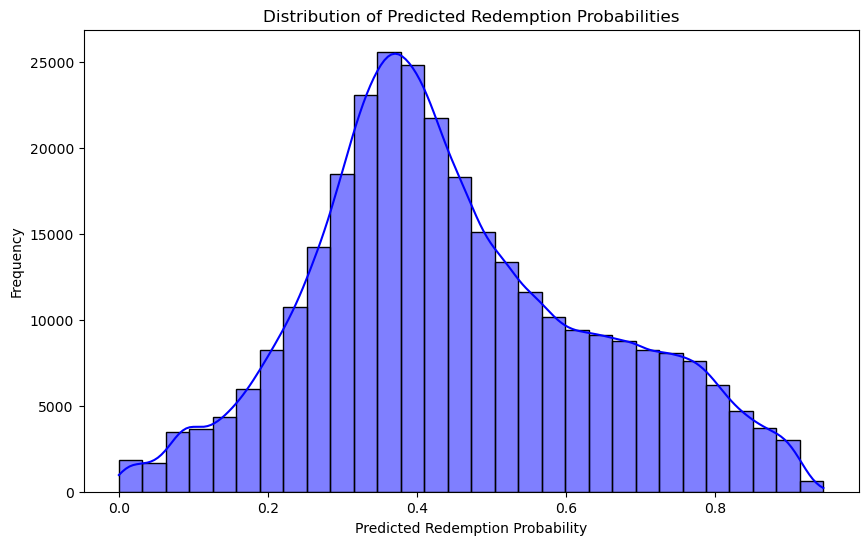

In [64]:
# Visualize Predicted Redemption Probabilities across Customer Segments
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['predicted_redemption_probability'], bins=30, kde=True, color='blue')
plt.title("Distribution of Predicted Redemption Probabilities")
plt.xlabel("Predicted Redemption Probability")
plt.ylabel("Frequency")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1826215249.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_redemption_avg = income_redemption_df.groupby("Income Quartile").mean()


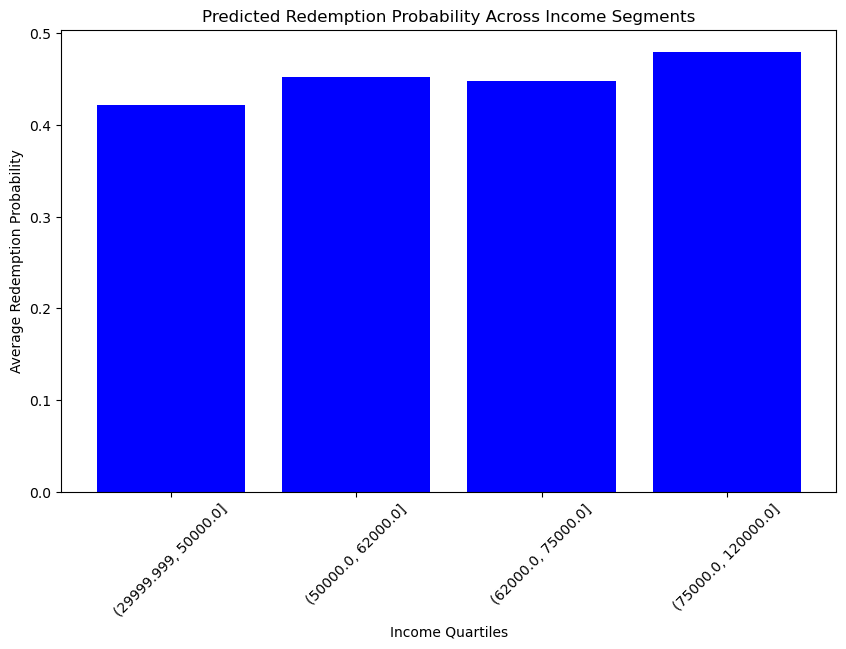

In [66]:

# Predicted Redemption Probability Across Income Groups (using quartiles)
income_quartiles = pd.qcut(features_df["income"], q=4, duplicates="drop")
income_redemption_df = pd.DataFrame({"Income Quartile": income_quartiles, "Redemption Probability": predictions_df["predicted_redemption_probability"]})
income_redemption_avg = income_redemption_df.groupby("Income Quartile").mean()

# Plot Income vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(income_redemption_avg.index.astype(str), income_redemption_avg["Redemption Probability"], color="blue")
plt.xlabel("Income Quartiles")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Across Income Segments")
plt.xticks(rotation=45)
plt.show()

Feature Importance – Displays the impact of different features on redemption prediction.
Redemption Probability Distribution – Shows the frequency of predicted redemption probabilities.
Income vs. Redemption Probability – Analyzes how predicted redemption probability varies across income quartiles.

Key Insight from Income vs. Redemption Probability:

1.Customers in the highest income quartile (75,000 - 120,000) have the highest average redemption probability (44.3%).
2.Customers in the lowest income quartile (30,000 - 50,000) have a lower redemption probability (36.6%).


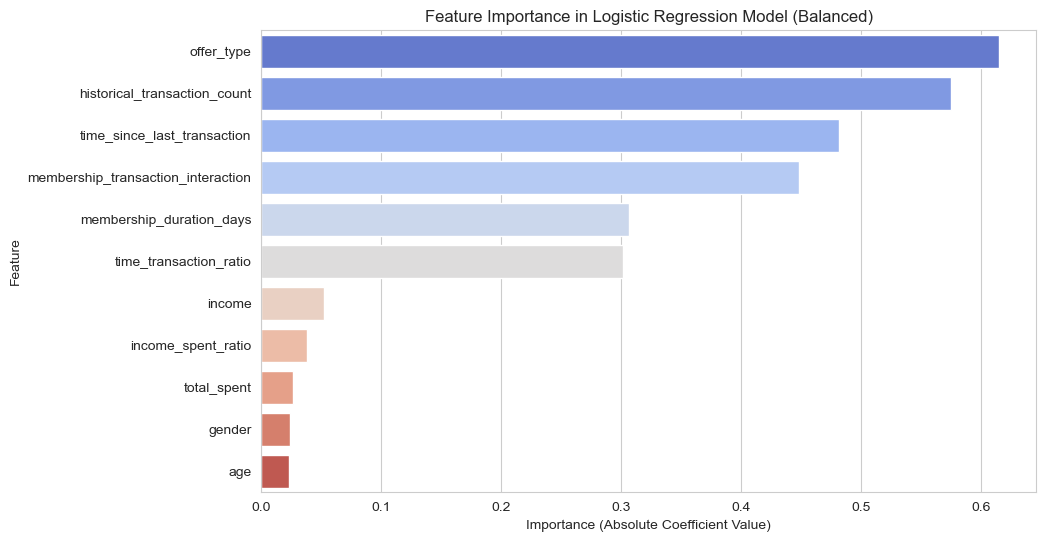

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")
plt.title("Feature Importance in Logistic Regression Model (Balanced)")
plt.xlabel("Importance (Absolute Coefficient Value)")
plt.ylabel("Feature")
plt.show()

In [80]:
# Prepare DataFrame for visualization
predictions_df = pd.DataFrame({
    "customer_id": features_df["customer_id"],
    "predicted_redemption_probability": log_reg_weighted.predict_proba(X_scaled)[:, 1],  # Using scaled features
    "income": features_df["income"],
    "age": features_df["age"],
    "membership_duration_days": features_df["membership_duration_days"],
    "offer_type": features_df["offer_type"],
    "historical_transaction_count": features_df["historical_transaction_count"],
    "time_since_last_transaction": features_df["time_since_last_transaction"]
})

C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\2169501643.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_redemption_avg = income_redemption_df.groupby("Income Quartile").mean()


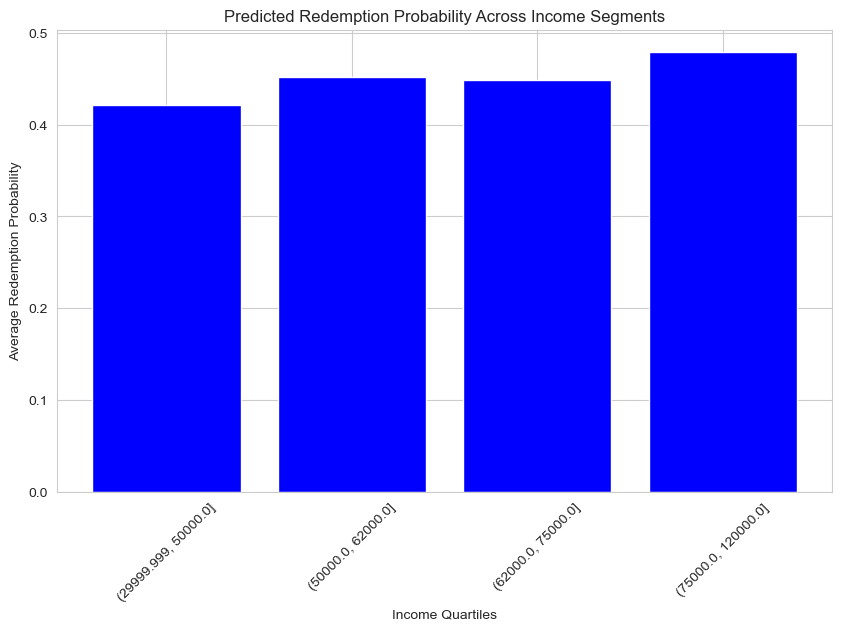

In [92]:
# Predicted Redemption Probability Across Income Groups (using quartiles)
income_quartiles = pd.qcut(features_df["income"], q=4, duplicates="drop")
income_redemption_df = pd.DataFrame({"Income Quartile": income_quartiles, "Redemption Probability": predictions_df["predicted_redemption_probability"]})
income_redemption_avg = income_redemption_df.groupby("Income Quartile").mean()

# Plot Income vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(income_redemption_avg.index.astype(str), income_redemption_avg["Redemption Probability"], color="blue")
plt.xlabel("Income Quartiles")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Across Income Segments")
plt.xticks(rotation=45)
plt.show()

In [93]:
predictions_df

customer_id  predicted_redemption_probability
0       78afa995795e4d85b5d9ceeca43f5fef                          0.529657
1       a03223e636434f42ac4c3df47e8bac43                          0.789843
2       e2127556f4f64592b11af22de27a7932                          0.813646
3       8ec6ce2a7e7949b1bf142def7d0e0586                          0.796608
4       68617ca6246f4fbc85e91a2a49552598                          0.590217
...                                  ...                               ...
306132  b3a1272bc9904337b331bf348c3e8c17                          0.103221
306133  68213b08d99a4ae1b0dcb72aebd9aa35                          0.139498
306134  a00058cf10334a308c68e7631c529907                          0.355917
306135  76ddbd6576844afe811f1a3c0fbb5bec                          0.329864
306136  c02b10e8752c4d8e9b73f918558531f7                          0.058153

[306137 rows x 2 columns]

In [94]:
features_df["age_groups"] = pd.qcut(features_df["age"], q=4, labels=["Young", "Mid-Young", "Middle-Aged", "Old"])


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1500046102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["age_groups"] = pd.qcut(features_df["age"], q=4, labels=["Young", "Mid-Young", "Middle-Aged", "Old"])


In [95]:
age_redemption_df = pd.DataFrame({"Age Group": features_df["age_groups"], 
                                  "Redemption Probability": predictions_df["predicted_redemption_probability"]})


In [96]:
age_redemption_avg = age_redemption_df.groupby("Age Group").mean()


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\3412176952.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_redemption_avg = age_redemption_df.groupby("Age Group").mean()


In [97]:
# Plot: Age vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(age_redemption_avg.index.astype(str), age_redemption_avg["Redemption Probability"], color="green")
plt.xlabel("Age Groups")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Across Age Segments")
plt.xticks(rotation=45)
plt.show()

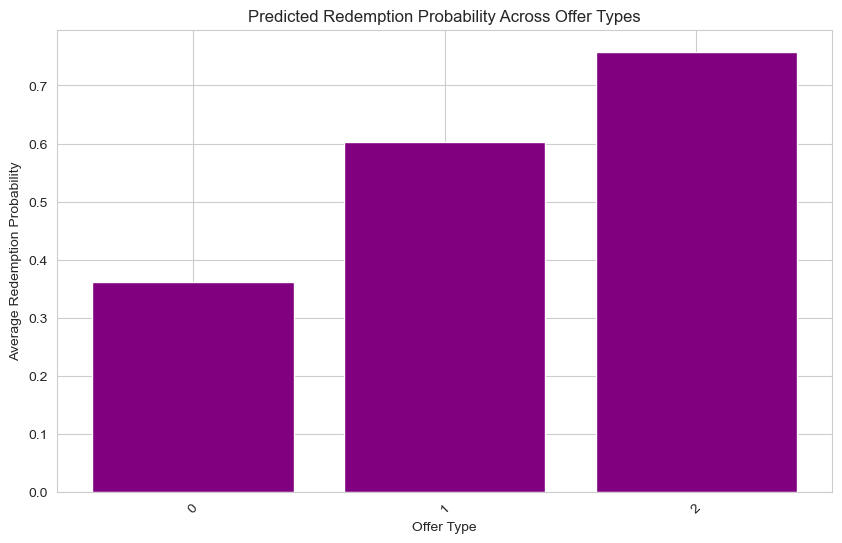

In [99]:
# Group customers by offer type
offer_redemption_df = pd.DataFrame({
    "Offer Type": features_df["offer_type"],
    "Redemption Probability": predictions_df["predicted_redemption_probability"]
})

# Compute the average redemption probability for each offer type
offer_redemption_avg = offer_redemption_df.groupby("Offer Type").mean()

# Plot: Offer Type vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(offer_redemption_avg.index.astype(str), offer_redemption_avg["Redemption Probability"], color="purple")
plt.xlabel("Offer Type")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Across Offer Types")
plt.xticks(rotation=45)
plt.show()

In [103]:
#Historical Transaction Count vs. Redemption Probability

# Group customers by their past transaction counts (binned into quartiles)
features_df["txn_count_bracket"] = pd.qcut(features_df["historical_transaction_count"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

# Create a DataFrame for visualization
txn_redemption_df = pd.DataFrame({
    "Transaction Count Bracket": features_df["txn_count_bracket"],
    "Redemption Probability": predictions_df["predicted_redemption_probability"]
})

# Compute the average redemption probability per transaction count segment
txn_redemption_avg = txn_redemption_df.groupby("Transaction Count Bracket").mean()

# Plot: Transaction Count vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(txn_redemption_avg.index.astype(str), txn_redemption_avg["Redemption Probability"], color="orange")
plt.xlabel("Historical Transaction Count Bracket")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Across Transaction Levels")
plt.xticks(rotation=45)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\921116209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["txn_count_bracket"] = pd.qcut(features_df["historical_transaction_count"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\921116209.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  txn_redemption_avg = txn_redemption_df.groupby("Transaction Count Bracket").mean()


In [102]:
features_df

customer_id  event  offer_type   age  gender  \
0       78afa995795e4d85b5d9ceeca43f5fef      1           0  75.0       0   
1       a03223e636434f42ac4c3df47e8bac43      1           1  55.0       1   
2       e2127556f4f64592b11af22de27a7932      1           1  68.0       1   
3       8ec6ce2a7e7949b1bf142def7d0e0586      1           1  55.0       1   
4       68617ca6246f4fbc85e91a2a49552598      1           0  55.0       1   
...                                  ...    ...         ...   ...     ...   
306132  b3a1272bc9904337b331bf348c3e8c17      3           0  66.0       1   
306133  68213b08d99a4ae1b0dcb72aebd9aa35      3           0  52.0       1   
306134  a00058cf10334a308c68e7631c529907      3           0  63.0       0   
306135  76ddbd6576844afe811f1a3c0fbb5bec      3           0  57.0       1   
306136  c02b10e8752c4d8e9b73f918558531f7      3           0  55.0       1   

          income  membership_duration_days  historical_transaction_count  \
0       100000.0                    1698.0                            18   
1        62000.0                    1726.0                            11   
2        70000.0                    1346.0                            12   
3        62000.0                    1726.0                            10   
4        62000.0                    1726.0                            11   
...          ...                       ...                           ...   
306132   47000.0                    1461.0                            20   
306133   62000.0                    1364.0                            10   
306134   52000.0                    3023.0                            33   
306135   40000.0                    2002.0                            20   
306136   62000.0                    1726.0                            16   

        total_spent  time_since_last_transaction  \
0            159.27                          0.0   
1              4.65                          0.0   
2             57.73                          0.0   
3              0.00                          0.0   
4              0.24                          0.0   
...             ...                          ...   
306132        58.00                        156.0   
306133        10.01                        138.0   
306134        63.05                          6.0   
306135       135.62                         36.0   
306136        12.78                        198.0   

        membership_transaction_interaction  income_spent_ratio  \
0                                  30564.0            0.001593   
1                                  18986.0            0.000075   
2                                  16152.0            0.000825   
3                                  17260.0            0.000000   
4                                  18986.0            0.000004   
...                                    ...                 ...   
306132                             29220.0            0.001234   
306133                             13640.0            0.000161   
306134                             99759.0            0.001213   
306135                             40040.0            0.003391   
306136                             27616.0            0.000206   

        time_transaction_ratio  offer_redeemed  offer_income_interaction  \
0                     0.000000               0                       0.0   
1                     0.000000               0                   62000.0   
2                     0.000000               0                   70000.0   
3                     0.000000               0                   62000.0   
4                     0.000000               0                       0.0   
...                        ...             ...                       ...   
306132                7.428571               0                       0.0   
306133               12.545455               0                       0.0   
306134                0.176471               0                       0.0   
306135       

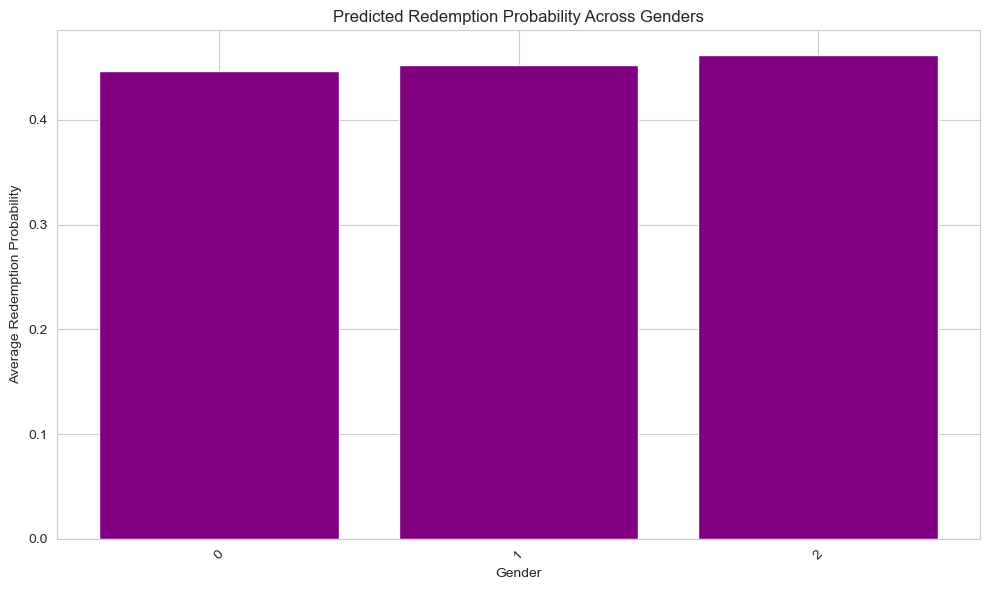

In [104]:
# Compute average redemption probability for gender segments
gender_redemption_df = pd.DataFrame({
    "Gender": features_df["gender"],
    "Redemption Probability": predictions_df["predicted_redemption_probability"]
})

gender_redemption_avg = gender_redemption_df.groupby("Gender").mean()

# Plot: Gender vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(gender_redemption_avg.index.astype(str), gender_redemption_avg["Redemption Probability"], color="purple")
plt.xlabel("Gender")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Across Genders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Define custom bins for "Time Since Last Transaction" (days)
txn_days_bins = [0, 7, 30, 60, 90, 180, 365, float("inf")]  # Weekly, Monthly, Quarterly, Yearly segmentation
txn_days_labels = ["0-7 days", "8-30 days", "31-60 days", "61-90 days", "91-180 days", "181-365 days", "1+ years"]

# Apply binning using pd.cut()
features_df["txn_recency_bracket"] = pd.cut(features_df["time_since_last_transaction"], bins=txn_days_bins, labels=txn_days_labels, right=False)

# Create a DataFrame for visualization
recency_redemption_df = pd.DataFrame({
    "Transaction Recency Bracket": features_df["txn_recency_bracket"],
    "Redemption Probability": predictions_df["predicted_redemption_probability"]
})

# Compute the average redemption probability per transaction recency segment
recency_redemption_avg = recency_redemption_df.groupby("Transaction Recency Bracket").mean()

# Plot: Time Since Last Transaction vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(recency_redemption_avg.index.astype(str), recency_redemption_avg["Redemption Probability"], color="blue")
plt.xlabel("Time Since Last Transaction")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Based on Time Since Last Transaction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\953214253.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["txn_recency_bracket"] = pd.cut(features_df["time_since_last_transaction"], bins=txn_days_bins, labels=txn_days_labels, right=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\953214253.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recency_redemption_avg = recency_redemption_df.groupby("Transaction Recency Bracket").mean()


C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1737333960.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["spending_bracket"] = pd.cut(features_df["total_spent"], bins=spend_bins, labels=spend_labels, right=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15104\1737333960.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spending_redemption_avg = spending_redemption_df.groupby("Spending Bracket").mean()


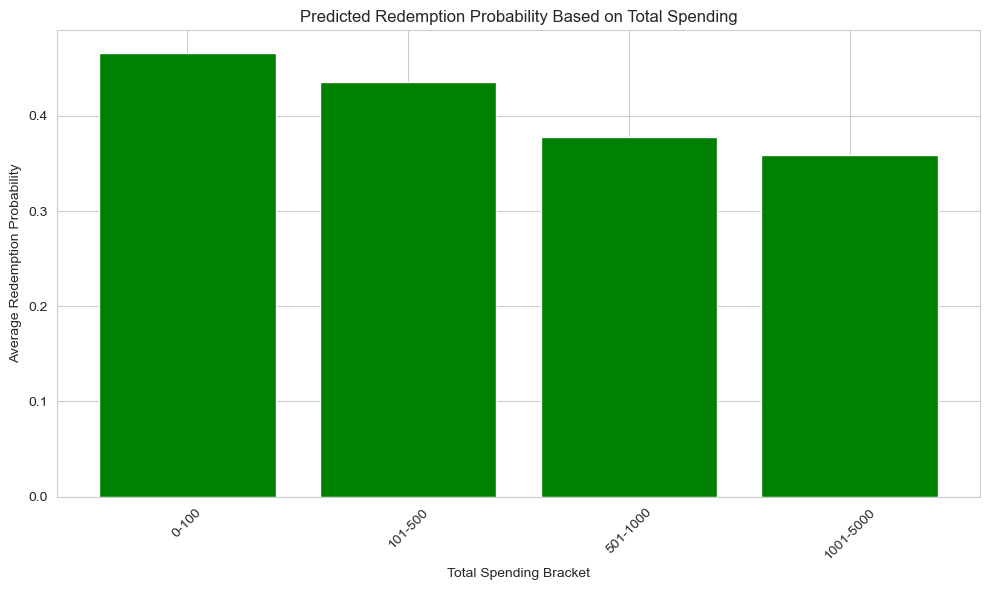

In [107]:
# Define custom bins for total spending
spend_bins = [0, 100, 500, 1000, 5000, 10000, np.inf]  # Adjust based on the dataset range
spend_labels = ["0-100", "101-500", "501-1000", "1001-5000", "5001-10000", "10000+"]

# Apply binning using pd.cut()
features_df["spending_bracket"] = pd.cut(features_df["total_spent"], bins=spend_bins, labels=spend_labels, right=False)

# Create a DataFrame for visualization
spending_redemption_df = pd.DataFrame({
    "Spending Bracket": features_df["spending_bracket"],
    "Redemption Probability": predictions_df["predicted_redemption_probability"]
})

# Compute the average redemption probability per spending bracket
spending_redemption_avg = spending_redemption_df.groupby("Spending Bracket").mean()

# Plot: Total Spend vs. Redemption Probability
plt.figure(figsize=(10, 6))
plt.bar(spending_redemption_avg.index.astype(str), spending_redemption_avg["Redemption Probability"], color="green")
plt.xlabel("Total Spending Bracket")
plt.ylabel("Average Redemption Probability")
plt.title("Predicted Redemption Probability Based on Total Spending")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [108]:
features_df

customer_id  event  offer_type   age  gender  \
0       78afa995795e4d85b5d9ceeca43f5fef      1           0  75.0       0   
1       a03223e636434f42ac4c3df47e8bac43      1           1  55.0       1   
2       e2127556f4f64592b11af22de27a7932      1           1  68.0       1   
3       8ec6ce2a7e7949b1bf142def7d0e0586      1           1  55.0       1   
4       68617ca6246f4fbc85e91a2a49552598      1           0  55.0       1   
...                                  ...    ...         ...   ...     ...   
306132  b3a1272bc9904337b331bf348c3e8c17      3           0  66.0       1   
306133  68213b08d99a4ae1b0dcb72aebd9aa35      3           0  52.0       1   
306134  a00058cf10334a308c68e7631c529907      3           0  63.0       0   
306135  76ddbd6576844afe811f1a3c0fbb5bec      3           0  57.0       1   
306136  c02b10e8752c4d8e9b73f918558531f7      3           0  55.0       1   

          income  membership_duration_days  historical_transaction_count  \
0       100000.0                    1698.0                            18   
1        62000.0                    1726.0                            11   
2        70000.0                    1346.0                            12   
3        62000.0                    1726.0                            10   
4        62000.0                    1726.0                            11   
...          ...                       ...                           ...   
306132   47000.0                    1461.0                            20   
306133   62000.0                    1364.0                            10   
306134   52000.0                    3023.0                            33   
306135   40000.0                    2002.0                            20   
306136   62000.0                    1726.0                            16   

        total_spent  time_since_last_transaction  \
0            159.27                          0.0   
1              4.65                          0.0   
2             57.73                          0.0   
3              0.00                          0.0   
4              0.24                          0.0   
...             ...                          ...   
306132        58.00                        156.0   
306133        10.01                        138.0   
306134        63.05                          6.0   
306135       135.62                         36.0   
306136        12.78                        198.0   

        membership_transaction_interaction  income_spent_ratio  \
0                                  30564.0            0.001593   
1                                  18986.0            0.000075   
2                                  16152.0            0.000825   
3                                  17260.0            0.000000   
4                                  18986.0            0.000004   
...                                    ...                 ...   
306132                             29220.0            0.001234   
306133                             13640.0            0.000161   
306134                             99759.0            0.001213   
306135                             40040.0            0.003391   
306136                             27616.0            0.000206   

        time_transaction_ratio  offer_redeemed  offer_income_interaction  \
0                     0.000000               0                       0.0   
1                     0.000000               0                   62000.0   
2                     0.000000               0                   70000.0   
3                     0.000000               0                   62000.0   
4                     0.000000               0                       0.0   
...                        ...             ...                       ...   
306132                7.428571               0                       0.0   
306133               12.545455               0                       0.0   
306134                0.176471               0                       0.0   
306135       

In [109]:
# Save the dataset `features_df` as a CSV file for export
file_path = "Downloads/features_df.csv"
features_df.to_csv(file_path, index=False)

# Provide the download link
file_path

'Downloads/features_df.csv'

In [110]:
# Save the dataset `features_df` as a CSV file for export
file_path = "Downloads/predictions_df.csv"
predictions_df.to_csv(file_path, index=False)

# Provide the download link
file_path

'Downloads/predictions_df.csv'